Some illustrations of how Deep Drilling Field observations are scheduled. 

In [1]:
import os

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rubin_scheduler.scheduler.surveys import ddf_slopes, match_cumulative, optimize_ddf_times, generate_ddf_scheduled_obs

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.scheduler.utils import ScheduledObservationArray
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import SURVEY_START_MJD, calc_season, ddf_locations


In [2]:
mjd0 = SURVEY_START_MJD

# Info about each DDF
data_file = os.path.join(get_data_dir(), "scheduler", "ddf_grid.npz")
ddfs = ddf_locations()
ddf_data = np.load(data_file)
ddf_grid = ddf_data["ddf_grid"].copy()
ddf_data.close()

# Just to make plotting easier later, let's crop off time before the survey starts
indx = np.where(ddf_grid["mjd"] < mjd0)[0].max()
ddf_grid = ddf_grid[indx:]

In [3]:
# Names and RA,dec locations for our standard DDFs
ddfs

{'ELAISS1': (np.float64(9.45), np.float64(-44.025)),
 'XMM_LSS': (np.float64(35.574999999999996), np.float64(-4.816666666666666)),
 'ECDFS': (np.float64(52.979166666666664), np.float64(-28.116666666666667)),
 'COSMOS': (np.float64(150.1083333333333), np.float64(2.233611111111111)),
 'EDFS_a': (np.float64(58.9), np.float64(-49.32)),
 'EDFS_b': (np.float64(63.6), np.float64(-47.6))}

In [4]:
# Handy pre-computed info about each DDF. Airmass, nominal depth at a bunch of timesteps
ddf_grid.dtype

dtype([('mjd', '<f8'), ('sun_alt', '<f8'), ('sun_n18_rising_next', '<f8'), ('ELAISS1_airmass', '<f8'), ('ELAISS1_sky_g', '<f8'), ('ELAISS1_m5_g', '<f8'), ('XMM_LSS_airmass', '<f8'), ('XMM_LSS_sky_g', '<f8'), ('XMM_LSS_m5_g', '<f8'), ('ECDFS_airmass', '<f8'), ('ECDFS_sky_g', '<f8'), ('ECDFS_m5_g', '<f8'), ('COSMOS_airmass', '<f8'), ('COSMOS_sky_g', '<f8'), ('COSMOS_m5_g', '<f8'), ('EDFS_a_airmass', '<f8'), ('EDFS_a_sky_g', '<f8'), ('EDFS_a_m5_g', '<f8'), ('EDFS_b_airmass', '<f8'), ('EDFS_b_sky_g', '<f8'), ('EDFS_b_m5_g', '<f8')])

Text(0.5, 1.0, 'ECDFS')

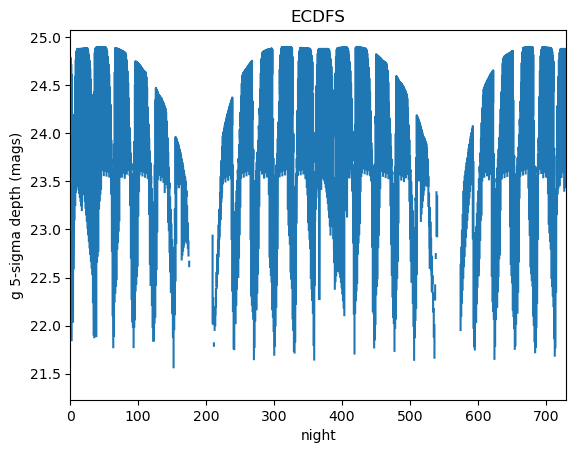

In [5]:

name = "ECDFS"
plt.plot(ddf_grid["mjd"] - mjd0, ddf_grid["%s_m5_g" % name])
plt.xlim(0,730)
plt.xlabel("night")
plt.ylabel("g 5-sigma depth (mags)")
plt.title(name)

In [6]:
# Run a script that sets up a desired total number of sequences vs time,
# Then fits observations given depth constraints
mjds, night_mjd, cumulative_desired, cumulative_sched = optimize_ddf_times(
    name,
    ddfs[name][0],
    ddf_grid,
    mjd_start=mjd0)

# night_mjd is just the rough time, then mjd is the time optimally placed 
# within that night.  


Text(0.5, 1.0, 'ECDFS')

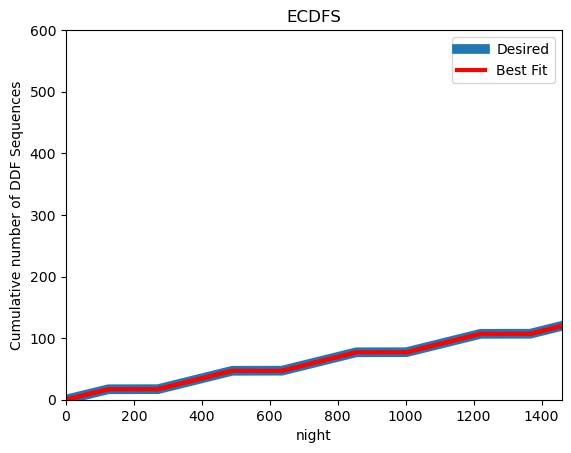

In [7]:
plt.plot(night_mjd - mjd0, cumulative_desired, label='Desired', linewidth=7)
plt.plot(night_mjd - mjd0, cumulative_sched, label='Best Fit', linewidth=3, color="r")
plt.legend()
plt.xlim([0,365*4])
plt.ylim([0,600])
plt.xlabel("night")
plt.ylabel("Cumulative number of DDF Sequences")
plt.title(name)
# There are some differences between desired and best fit, since the field is not always visible

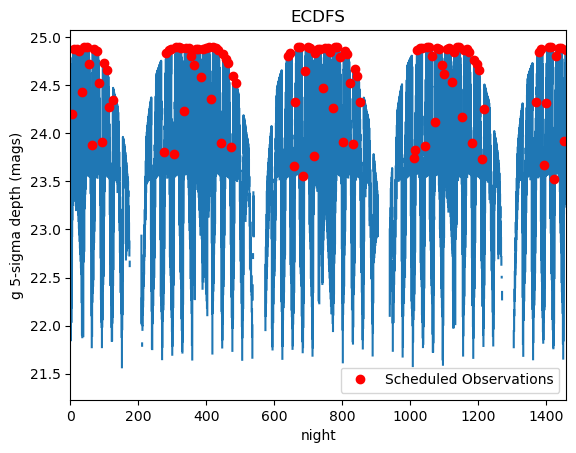

In [8]:
plt.plot(ddf_grid["mjd"] - mjd0, ddf_grid["%s_m5_g" % name])
plt.xlim(0,365*4)
plt.xlabel("night")
plt.ylabel("g 5-sigma depth (mags)")
plt.title(name)

m5_interp = np.interp(mjds, ddf_grid["mjd"], ddf_grid["%s_m5_g" % name])

plt.plot(np.array(mjds)-mjd0, m5_interp, 'ro', label="Scheduled Observations")
leg = plt.legend()
# Now we see where the optimizer put the observations, and we can see there was a limit 
# where it wouldn't schedule if the depth was shallower than 23.5 mag.

Text(0.5, 1.0, 'COSMOS')

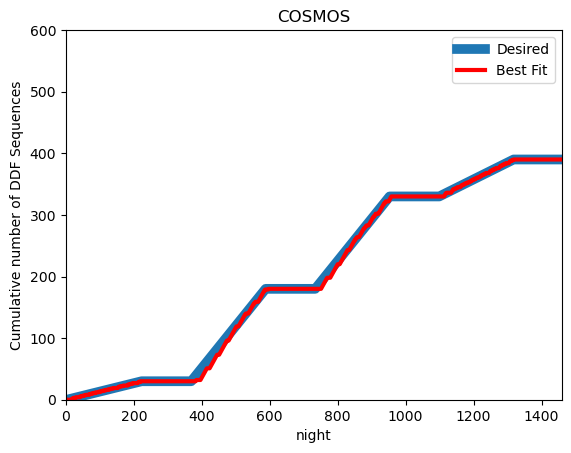

In [9]:
ddf_kwargs = {}
# do it again with COSMOS, since it is set up to have higher cadence the first few years
name = "COSMOS"

ddf_kwargs["COSMOS"] = {
            "season_seq": 30,
            "boost_early_factor": 5.0,
            "boost_factor_third": 2,
        }

mjds, night_mjd, cumulative_desired, cumulative_sched = optimize_ddf_times(
    name,
    ddfs[name][0],
    ddf_grid,
    mjd_start=mjd0,
    **ddf_kwargs[name])

plt.plot(night_mjd - mjd0, cumulative_desired, label='Desired', linewidth=7)
plt.plot(night_mjd - mjd0, cumulative_sched, label='Best Fit', linewidth=3, color="r")
plt.legend()
plt.xlim([0,365*4])
plt.ylim([0,600])
plt.xlabel("night")
plt.ylabel("Cumulative number of DDF Sequences")
plt.title(name)

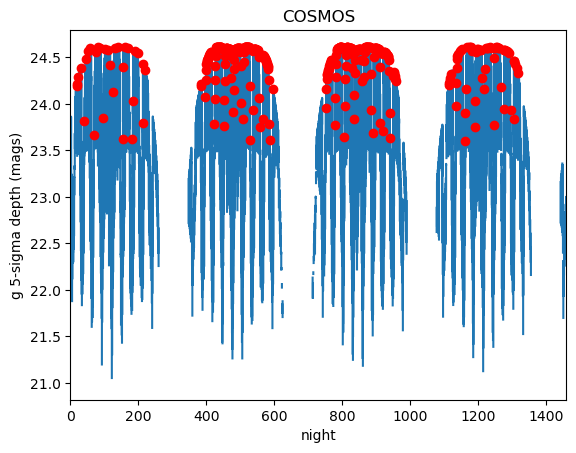

In [10]:
plt.plot(ddf_grid["mjd"] - mjd0, ddf_grid["%s_m5_g" % name])
plt.xlim(0,365*4)
plt.xlabel("night")
plt.ylabel("g 5-sigma depth (mags)")
plt.title(name)

m5_interp = np.interp(mjds, ddf_grid["mjd"], ddf_grid["%s_m5_g" % name])

plt.plot(np.array(mjds)-mjd0, m5_interp, 'ro')


In [11]:
# So we have some routines to pick which nights to have a sequence
# Then find the best time within those nights. 
# Finally, generate_ddf_scheduled_obs converts each of those times to a sequence of observations

In [12]:
observations = generate_ddf_scheduled_obs()
observations

Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a


ScheduledObservationArray([(0, 0.16493361, -0.7683812 , 60985.01249967, 60987.01249967, 30., 'u', '', 0., 0., 0., 0., 1, 'DD:ELAISS1', 'DD:ELAISS1', 'DD', 'FBS', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 21., -0.31415927, 0.43633231, False),
                           (0, 0.16493361, -0.7683812 , 60985.01249967, 60987.01249967, 30., 'u', '', 0., 0., 0., 0., 1, 'DD:ELAISS1', 'DD:ELAISS1', 'DD', 'FBS', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 21., -0.31415927, 0.43633231, False),
                           (0, 0.16493361, -0.7683812 , 60985.01249967, 60987.01249967, 30., 'u', '', 0., 0., 0., 0., 1, 'DD:ELAISS1', 'DD:ELAISS1', 'DD', 'FBS', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 21., -0.31415927, 0.43633231, False),
                           ...,
                           (0, 1.1100294 , -0.83077672, 64629.25208215, 64631.25208215, 30., 'y', '', 0., 0., 0., 0., 2, 'DD:EDFS_b', 'DD:EDFS_b', 'DD', 'FBS', 0.01041667, 0.05235988, 0.43633231, 1.48352986, 3., 

Text(0.5, 1.0, 'All DDFs')

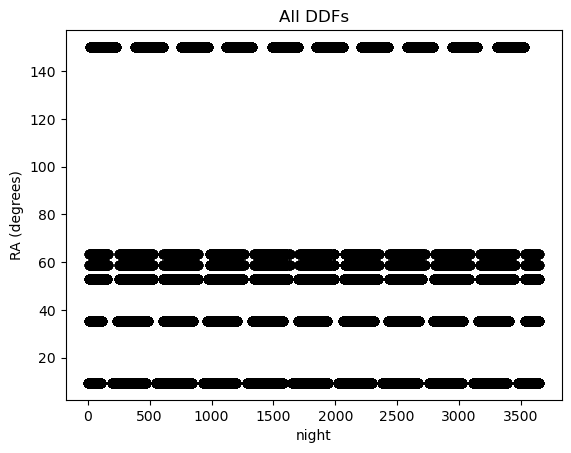

In [13]:
plt.plot(observations["mjd"]-mjd0, np.degrees(observations["RA"]), 'ko', alpha=.1)
plt.xlabel("night")
plt.ylabel("RA (degrees)")
plt.title("All DDFs")

In [14]:
print("Name, N obs scheduled \n")
for name in np.unique(observations["target_name"]):
    t = np.where(observations["target_name"] == name)[0]
    print(name, t.size)

Name, N obs scheduled 

DD:COSMOS 61500
DD:ECDFS 29900
DD:EDFS_a 15000
DD:EDFS_b 15000
DD:ELAISS1 30000
DD:XMM_LSS 30000
